In [1]:
# This is heavily based off https://github.com/asrivat1/DeepLearningVideoGames
import os
os.environ['SDL_VIDEODRIVER']='dummy'
import random
from collections import deque
from pong_player import PongPlayer
import tensorflow as tf
import numpy as np
import cv2
from pygame.constants import K_DOWN, K_UP, K_RIGHT


class DeepQPongPlayer(PongPlayer):
    ACTIONS_COUNT = 3  # number of valid actions. In this case up, still and down
    FUTURE_REWARD_DISCOUNT = 0.99  # decay rate of past observations
    OBSERVATION_STEPS = 20000.  # time steps to observe before training
    EXPLORE_STEPS = 500000.  # frames over which to anneal epsilon
    INITIAL_RANDOM_ACTION_PROB = 1.0  # starting chance of an action being random
    FINAL_RANDOM_ACTION_PROB = 0.05  # final chance of an action being random
    MEMORY_SIZE = 50000  # number of observations to remember
    MINI_BATCH_SIZE = 100  # size of mini batches
    STATE_FRAMES = 4  # number of frames to store in the state
    RESIZED_SCREEN_X, RESIZED_SCREEN_Y = (80, 80)
    OBS_LAST_STATE_INDEX, OBS_ACTION_INDEX, OBS_REWARD_INDEX, OBS_CURRENT_STATE_INDEX, OBS_TERMINAL_INDEX = range(5)
    SAVE_EVERY_X_STEPS = 50000
    LEARN_RATE = 1e-6
    STORE_SCORES_LEN = 200.

    def __init__(self, checkpoint_path="deep_q_pong_networks", playback_mode=False, verbose_logging=False):
        """
        Example of deep q network for pong

        :param checkpoint_path: directory to store checkpoints in
        :type checkpoint_path: str
        :param playback_mode: if true games runs in real time mode and demos itself running
        :type playback_mode: bool
        :param verbose_logging: If true then extra log information is printed to std out
        :type verbose_logging: bool
        """
        self.reward_history = deque()
        self.reward_memory = 0
        
        self._playback_mode = playback_mode
        super(DeepQPongPlayer, self).__init__(force_game_fps=8, run_real_time=playback_mode)
        self.verbose_logging = verbose_logging
        self._checkpoint_path = checkpoint_path
        with tf.device('/gpu:0'):
            self._session = tf.Session()
            self._input_layer, self._output_layer = DeepQPongPlayer._create_network()

            self._action = tf.placeholder("float", [None, self.ACTIONS_COUNT])
            self._target = tf.placeholder("float", [None])

            readout_action = tf.reduce_sum(tf.multiply(self._output_layer, self._action), reduction_indices=1)

            cost = tf.reduce_mean(tf.square(self._target - readout_action))
            self._train_operation = tf.train.AdamOptimizer(self.LEARN_RATE).minimize(cost)

        self._observations = deque()
        self._last_scores = deque()

        # set the first action to do nothing
        self._last_action = np.zeros(self.ACTIONS_COUNT)
        self._last_action[1] = 1

        self._last_state = None
        self._probability_of_random_action = self.INITIAL_RANDOM_ACTION_PROB
        self._time = 0

        self._session.run(tf.global_variables_initializer())

        if not os.path.exists(self._checkpoint_path):
            os.mkdir(self._checkpoint_path)
        
        self._saver = tf.train.Saver()
        checkpoint = tf.train.get_checkpoint_state(self._checkpoint_path)

        if checkpoint and checkpoint.model_checkpoint_path:
            self._saver.restore(self._session, checkpoint.model_checkpoint_path)
            print("Loaded checkpoints %s" % checkpoint.model_checkpoint_path)
        elif playback_mode:
            raise Exception("Could not load checkpoints for playback")

    def get_keys_pressed(self, screen_array, reward, terminal):
        # scale down screen image
        screen_resized_grayscaled = cv2.cvtColor(cv2.resize(screen_array,
                                                            (self.RESIZED_SCREEN_X, self.RESIZED_SCREEN_Y)),
                                                 cv2.COLOR_BGR2GRAY)

        # set the pixels to all be 0. or 1.
        _, screen_resized_binary = cv2.threshold(screen_resized_grayscaled, 1, 255, cv2.THRESH_BINARY)

        if reward != 0.0:
            self._last_scores.append(reward)
            if len(self._last_scores) > self.STORE_SCORES_LEN:
                self._last_scores.popleft()

        # first frame must be handled differently
        if self._last_state is None:
            # the _last_state will contain the image data from the last self.STATE_FRAMES frames
            self._last_state = np.stack(tuple(screen_resized_binary for _ in range(self.STATE_FRAMES)), axis=2)

            return DeepQPongPlayer._key_presses_from_action(self._last_action)

        screen_resized_binary = np.reshape(screen_resized_binary,
                                               (self.RESIZED_SCREEN_X, self.RESIZED_SCREEN_Y, 1)) ## 图像处理结束
        
        current_state = np.append(self._last_state[:, :, 1:], screen_resized_binary, axis=2)

        if not self._playback_mode:
            # store the transition in previous_observations
            self._observations.append((self._last_state, self._last_action, reward, current_state, terminal))

            if len(self._observations) > self.MEMORY_SIZE:
                self._observations.popleft()

            # only train if done observing
            if len(self._observations) > self.OBSERVATION_STEPS:
                self._train()
                self._time += 1
            elif ((len(self._observations)+1) % 1000 == 0):
                print('Observation -', len(self._observations)+1,'/',self.OBSERVATION_STEPS)

        # update the old values
        self._last_state = current_state

        self._last_action = self._choose_next_action() ## 后面会定义好

        if not self._playback_mode:
            # gradually reduce the probability of a random actionself.
            if self._probability_of_random_action > self.FINAL_RANDOM_ACTION_PROB \
                    and len(self._observations) > self.OBSERVATION_STEPS:
                self._probability_of_random_action -= \
                    (self.INITIAL_RANDOM_ACTION_PROB - self.FINAL_RANDOM_ACTION_PROB) / self.EXPLORE_STEPS
            """
            print("Time: %s random_action_prob: %s reward %s scores differential %s" %
                  (self._time, self._probability_of_random_action, reward,
                   sum(self._last_scores) / self.STORE_SCORES_LEN))
            """
            self.reward_memory += reward
            if (self._time > 1000 and self._time % 1000 == 0):
                self.reward_history.append(self.reward_memory / 1000)
                self.reward_memory = 0
                print("Training - Time: %s; Reward: %s" % (self._time, self.reward_history[-1]))
            if (self._time >= self.EXPLORE_STEPS-1):
                return [K_RIGHT]    
        return DeepQPongPlayer._key_presses_from_action(self._last_action)

    def _choose_next_action(self):
        new_action = np.zeros([self.ACTIONS_COUNT])

        if (not self._playback_mode) and (random.random() <= self._probability_of_random_action):
            # choose an action randomly
            action_index = random.randrange(self.ACTIONS_COUNT)
        else:
            # choose an action given our last state
            readout_t = self._session.run(self._output_layer, feed_dict={self._input_layer: [self._last_state]})[0]
            if self.verbose_logging:
                print("Action Q-Values are %s" % readout_t)
            action_index = np.argmax(readout_t)

        new_action[action_index] = 1
        return new_action # 

    def _train(self):
        # sample a mini_batch to train on
        mini_batch = random.sample(self._observations, self.MINI_BATCH_SIZE)
        # get the batch variables
        previous_states = [d[self.OBS_LAST_STATE_INDEX] for d in mini_batch]
        actions = [d[self.OBS_ACTION_INDEX] for d in mini_batch]
        rewards = [d[self.OBS_REWARD_INDEX] for d in mini_batch]
        current_states = [d[self.OBS_CURRENT_STATE_INDEX] for d in mini_batch]
        agents_expected_reward = []
        # this gives us the agents expected reward for each action we might
        agents_reward_per_action = self._session.run(self._output_layer, feed_dict={self._input_layer: current_states})
        for i in range(len(mini_batch)):
            if mini_batch[i][self.OBS_TERMINAL_INDEX]:
                # this was a terminal frame so there is no future reward...
                agents_expected_reward.append(rewards[i])
            else:
                agents_expected_reward.append(
                    rewards[i] + self.FUTURE_REWARD_DISCOUNT * np.max(agents_reward_per_action[i]))

        # learn that these actions in these states lead to this reward
        self._session.run(self._train_operation, feed_dict={
            self._input_layer: previous_states,
            self._action: actions,
            self._target: agents_expected_reward})

        # save checkpoints for later
        if self._time % self.SAVE_EVERY_X_STEPS == 0:
            self._saver.save(self._session, self._checkpoint_path + '/network', global_step=self._time)

    @staticmethod
    def _create_network():
        # network weights
        with tf.device('/gpu:0'):
            convolution_weights_1 = tf.Variable(tf.truncated_normal([8, 8, DeepQPongPlayer.STATE_FRAMES, 32], stddev=0.01))
            convolution_bias_1 = tf.Variable(tf.constant(0.01, shape=[32]))

            convolution_weights_2 = tf.Variable(tf.truncated_normal([4, 4, 32, 64], stddev=0.01))
            convolution_bias_2 = tf.Variable(tf.constant(0.01, shape=[64]))

            convolution_weights_3 = tf.Variable(tf.truncated_normal([3, 3, 64, 64], stddev=0.01))
            convolution_bias_3 = tf.Variable(tf.constant(0.01, shape=[64]))

            feed_forward_weights_1 = tf.Variable(tf.truncated_normal([256, 256], stddev=0.01))
            feed_forward_bias_1 = tf.Variable(tf.constant(0.01, shape=[256]))

            feed_forward_weights_2 = tf.Variable(tf.truncated_normal([256, DeepQPongPlayer.ACTIONS_COUNT], stddev=0.01))
            feed_forward_bias_2 = tf.Variable(tf.constant(0.01, shape=[DeepQPongPlayer.ACTIONS_COUNT]))

            input_layer = tf.placeholder("float", [None, DeepQPongPlayer.RESIZED_SCREEN_X, DeepQPongPlayer.RESIZED_SCREEN_Y,
                                               DeepQPongPlayer.STATE_FRAMES])

            hidden_convolutional_layer_1 = tf.nn.relu(
                tf.nn.conv2d(input_layer, convolution_weights_1, strides=[1, 4, 4, 1], padding="SAME") + convolution_bias_1)

            hidden_max_pooling_layer_1 = tf.nn.max_pool(hidden_convolutional_layer_1, ksize=[1, 2, 2, 1],
                                                    strides=[1, 2, 2, 1], padding="SAME")

            hidden_convolutional_layer_2 = tf.nn.relu(
                tf.nn.conv2d(hidden_max_pooling_layer_1, convolution_weights_2, strides=[1, 2, 2, 1],
                         padding="SAME") + convolution_bias_2)

            hidden_max_pooling_layer_2 = tf.nn.max_pool(hidden_convolutional_layer_2, ksize=[1, 2, 2, 1],
                                                    strides=[1, 2, 2, 1], padding="SAME")

            hidden_convolutional_layer_3 = tf.nn.relu(
                tf.nn.conv2d(hidden_max_pooling_layer_2, convolution_weights_3,
                         strides=[1, 1, 1, 1], padding="SAME") + convolution_bias_3)

            hidden_max_pooling_layer_3 = tf.nn.max_pool(hidden_convolutional_layer_3, ksize=[1, 2, 2, 1],
                                                    strides=[1, 2, 2, 1], padding="SAME")

            hidden_convolutional_layer_3_flat = tf.reshape(hidden_max_pooling_layer_3, [-1, 256])

            final_hidden_activations = tf.nn.relu(
                tf.matmul(hidden_convolutional_layer_3_flat, feed_forward_weights_1) + feed_forward_bias_1)

            output_layer = tf.matmul(final_hidden_activations, feed_forward_weights_2) + feed_forward_bias_2

        return input_layer, output_layer 

    @staticmethod
    def _key_presses_from_action(action_set):
        if action_set[0] == 1:
            return [K_DOWN]
        elif action_set[1] == 1:
            return []
        elif action_set[2] == 1:
            return [K_UP]
        raise Exception("Unexpected action") 



player = DeepQPongPlayer()
player.start()


Observation - 1000 / 20000.0
Observation - 2000 / 20000.0
Observation - 3000 / 20000.0
Observation - 4000 / 20000.0
Observation - 5000 / 20000.0
Observation - 6000 / 20000.0
Observation - 7000 / 20000.0
Observation - 8000 / 20000.0
Observation - 9000 / 20000.0
Observation - 10000 / 20000.0
Observation - 11000 / 20000.0
Observation - 12000 / 20000.0
Observation - 13000 / 20000.0
Observation - 14000 / 20000.0
Observation - 15000 / 20000.0
Observation - 16000 / 20000.0
Observation - 17000 / 20000.0
Observation - 18000 / 20000.0
Observation - 19000 / 20000.0
Observation - 20000 / 20000.0
Training - Time: 2000; Reward: -1.284
Training - Time: 3000; Reward: -0.055
Training - Time: 4000; Reward: -0.064
Training - Time: 5000; Reward: -0.074
Training - Time: 6000; Reward: -0.062
Training - Time: 7000; Reward: -0.06
Training - Time: 8000; Reward: -0.063
Training - Time: 9000; Reward: -0.048
Training - Time: 10000; Reward: -0.048
Training - Time: 11000; Reward: -0.071
Training - Time: 12000; Rewa

Training - Time: 196000; Reward: -0.045
Training - Time: 197000; Reward: -0.035
Training - Time: 198000; Reward: -0.033
Training - Time: 199000; Reward: -0.037
Training - Time: 200000; Reward: -0.015
Training - Time: 201000; Reward: -0.04
Training - Time: 202000; Reward: -0.048
Training - Time: 203000; Reward: -0.028
Training - Time: 204000; Reward: -0.034
Training - Time: 205000; Reward: -0.017
Training - Time: 206000; Reward: -0.026
Training - Time: 207000; Reward: -0.03
Training - Time: 208000; Reward: -0.029
Training - Time: 209000; Reward: -0.022
Training - Time: 210000; Reward: -0.03
Training - Time: 211000; Reward: -0.03
Training - Time: 212000; Reward: -0.03
Training - Time: 213000; Reward: -0.023
Training - Time: 214000; Reward: -0.028
Training - Time: 215000; Reward: -0.038
Training - Time: 216000; Reward: -0.031
Training - Time: 217000; Reward: -0.02
Training - Time: 218000; Reward: -0.031
Training - Time: 219000; Reward: -0.041
Training - Time: 220000; Reward: -0.022
Traini

Training - Time: 402000; Reward: -0.002
Training - Time: 403000; Reward: -0.008
Training - Time: 404000; Reward: -0.005
Training - Time: 405000; Reward: -0.011
Training - Time: 406000; Reward: -0.018
Training - Time: 407000; Reward: -0.015
Training - Time: 408000; Reward: -0.018
Training - Time: 409000; Reward: -0.011
Training - Time: 410000; Reward: -0.007
Training - Time: 411000; Reward: -0.012
Training - Time: 412000; Reward: -0.008
Training - Time: 413000; Reward: -0.008
Training - Time: 414000; Reward: -0.003
Training - Time: 415000; Reward: 0.001
Training - Time: 416000; Reward: -0.008
Training - Time: 417000; Reward: -0.009
Training - Time: 418000; Reward: -0.007
Training - Time: 419000; Reward: 0.001
Training - Time: 420000; Reward: -0.002
Training - Time: 421000; Reward: -0.001
Training - Time: 422000; Reward: -0.01
Training - Time: 423000; Reward: -0.004
Training - Time: 424000; Reward: 0.0
Training - Time: 425000; Reward: -0.007
Training - Time: 426000; Reward: -0.007
Traini

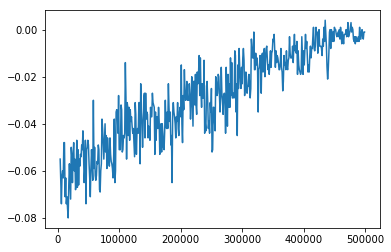

In [11]:
import matplotlib.pyplot as plt
#player.reward_history.popleft()
plt.plot(range(4000,500000,1000),player.reward_history)
plt.show()